In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import itertools

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import TomekLinks, OneSidedSelection, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule
from keras.models import load_model
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D, Activation
from tqdm import tqdm
from collections import Counter
from eunjeon import Mecab
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
tensorflow.random.set_seed(2)

상폐기업뉴스 = pd.read_csv('../Step3-1_뉴스전처리/전처리후/상폐기업뉴스전처리.csv')
상폐기업뉴스추가 = pd.read_csv('../Step3-1_뉴스전처리/전처리후/상폐기업뉴스전처리추가.csv')
상폐기업뉴스 = pd.concat([상폐기업뉴스, 상폐기업뉴스추가])

정상기업뉴스 = pd.read_csv('../Step3-1_뉴스전처리/전처리후/정상기업뉴스전처리.csv', encoding='cp949')
정상기업뉴스추가 = pd.read_csv('../Step3-1_뉴스전처리/전처리후/정상기업뉴스전처리추가.csv')
정상기업뉴스 = pd.concat([정상기업뉴스, 정상기업뉴스추가])

뉴스 = pd.concat([정상기업뉴스, 상폐기업뉴스])
뉴스.reset_index(drop=True, inplace=True)
뉴스

,기업,기사발행일,기사제목,뉴스기사본문전처리
0,씨제이이엔엠,2011.12.13. 오전 8:24,"씨제이이엔엠, 유형자산 취득 후 처분 예정",씨제이이엔엠은 억 만원 규모의 유형자산을 취득한다고 일 공시했다. 판교신도시 특별계...
1,씨제이이엔엠,2011.11.17. 오전 8:47,시초가 소폭 하락 예상 - 코스닥 동시호가,일 코스닥 시장은 소폭 하락 출발이 예상된다.코스닥 시장은 현재 시가총액 상위 종목...
2,안랩,2011.12.06. 오전 10:35,"안랩, `V3ㆍ네트워크 보안장비 연동` 특허 획득",안철수연구소는 네트워크 통합보안 장비 트러스가드에 적용된 기술인 단말 장치 및 상기...
3,안랩,2011.10.10. 오후 3:03,"한컴과 안랩, 10월은 특별한 달",월을 맞아 국내 대표 소프트웨어 업체들이 잇따라 재도약을 선언하며 성장세를 끌어올리...
4,포스코아이씨티,2011.08.31. 오전 10:32,"포스코아이씨티, POSCO IT Outsourcing SLA 계약금액 증가",포스코아이씨티는 일 지난 년 월 일 공시한 년 계약관련 계약금액을 억 만 원...
...,...,...,...,...
15371,코썬바이오,2020.01.10. 오후 7:40,"코썬바이오, 불성실공시법인 지정",한국거래소 코스닥시장본부는 일 코썬바이오가 지난해 월 최대주주 변경을 수반하는 주...
15372,코썬바이오,2019.12.20. 오후 6:53,"거래소, 코썬바이오 불성실 공시법인 지정…23일 주식거래 정지",한국거래소 코스닥시장본부는 오는 일 코썬바이오를 불성실 공시 법인으로 지정한다고 ...
15373,코썬바이오,2019.12.23. 오후 5:17,코썬바이오 불성실 공시법인 지정예고,코썬바이오는 공시불이행으로 불성실 공시법인으로 지정예고 됐다고 일 공시했다.사유는 ...
15374,코썬바이오,2019.12.23. 오후 5:23,"거래소, 코썬바이오 불성실 공시법인 지정예고",한국거래소 코스닥시장본부는 코썬바이오가 공시불이행에 따라 불성실 공시법인으로 지정...


In [3]:
mecab = Mecab()
# Mecab으로 명사 추출
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: mecab.nouns(x))
# 한 글자 단어 제거
뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if len(word) > 1])
뉴스.reset_index(inplace=True, drop=True)

기사의 최대 길이 : 2529
기사의 평균 길이 : 152.58285639958376


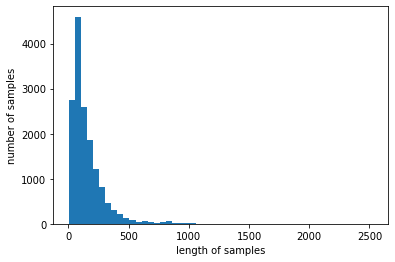

In [5]:
## 패딩을 위해 기사 평균길이 확인
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [4]:
분류단어 = ['폐지', '격성', '퇴출', '실질', '심사', '속개', '이의', '심의', '거절']
분류단어 = '|'.join(분류단어)
분류단어

'폐지|격성|퇴출|실질|심사|속개|이의|심의|거절'

In [5]:
# 분류단어가 하나라도 존재할 경우 부정기사로 분류
라벨 = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word in 분류단어])
라벨 = 라벨.apply(lambda x: 1 if (len(x)>=1) else 0)
뉴스['긍정부정기사분류'] = 라벨

<AxesSubplot:xlabel='긍정부정기사분류'>

c:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44557 (\N{HANGUL SYLLABLE GEUNG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dbswo\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:151

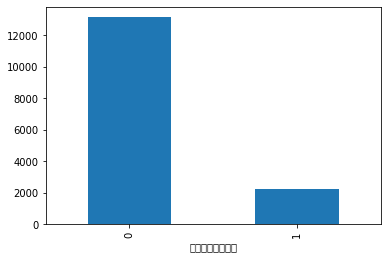

In [22]:
import matplotlib.pyplot as plt
뉴스.groupby(['긍정부정기사분류']).count().iloc[:,1].plot.bar()

In [7]:
## 단어 빈도 수를 세기 위해서 길이가 1보다 긴 단어들을 다 결합해서 저장
remove_word = [x for x in 뉴스['뉴스기사본문전처리'] if len(x) > 1]
remove_word = list(itertools.chain(*remove_word))
remove_word

## 단어별 빈도수 추출
frequent = Counter(remove_word).most_common()

## 전체기사에서 빈도 수 20이하인 단어 제거하기 위해 리스트 생성
minimum_words = []
for item, count in frequent:
    if count <= 20:
        minimum_words.append(item)
minimum_words = '|'.join(minimum_words)

뉴스['뉴스기사본문전처리'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: [word for word in x if word not in minimum_words])

기사의 최대 길이 : 710
기사의 평균 길이 : 45.16226586888658


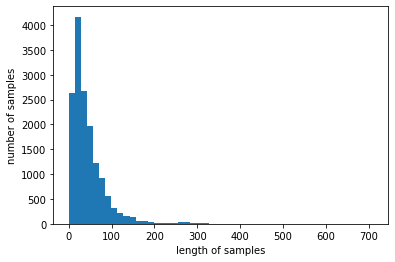

In [8]:
## 제거후 패딩위해 기사 평균 길이 확인
print('기사의 최대 길이 :',max(len(review) for review in 뉴스['뉴스기사본문전처리']))
print('기사의 평균 길이 :',sum(map(len, 뉴스['뉴스기사본문전처리']))/len(뉴스['뉴스기사본문전처리']))
plt.hist([len(review) for review in 뉴스['뉴스기사본문전처리']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
뉴스['기사길이'] = 뉴스['뉴스기사본문전처리'].apply(lambda x: len(x))
뉴스['기사길이'].describe()

## 샘플링 하지 않은 경우

In [48]:
## 최대한 많은 단어를 학습하기 위해 x_train이 아닌 전체에 대해 학습
tokenizer = Tokenizer ()
tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])

In [49]:
## 텍스트데이터를 훈련, 평가용으로 나누기
x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2)
max_review_length = 100

## 임베딩하기 위해서는 먼저 텍스트를 정수화 해줘야 함
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

## 모델에 넣기 위해서는 전체 길이 일정해야 함. 100글자 이상부터는 제거하고 미만인 경우는 패딩
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

print("Shape of train data:", x_train.shape)
print("Shape of Test data:", x_test.shape)

Shape of train data: (12300, 100)
Shape of Test data: (3076, 100)


In [19]:
# 모델의 설정
model = Sequential()
model.add(Embedding(input_dim=12300, output_dim=32, input_length=max_review_length))
model.add(Dropout(0.5))
# strides : 컨볼루션 커널 이동 간격 / 보폭
model.add(Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		tensorflow.keras.metrics.Recall(),
			tensorflow.keras.metrics.Precision()
			 ])
        
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           393600    
                                                                 
 dropout (Dropout)           (None, 100, 32)           0         
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            10304     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 64)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 55)                26400     
                                                                 
 dense (Dense)               (None, 1)                 56        
                                                        

In [ ]:
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

## 오버샘플링

In [ ]:
sampling = [SMOTE, BorderlineSMOTE, ADASYN]
columns = ['f1_score']
df = pd.DataFrame(columns=columns)
max_review_length = 100

for i in sampling:
    
   # 모델의 설정
    model = Sequential()
    model.add(Embedding(input_dim=7239, output_dim=32, input_length=max_review_length))
    model.add(Dropout(0.5))
    # strides : 컨볼루션 커널 이동 간격 / 보폭
    model.add(LSTM(55))
    model.add(Dense(10, activation='relu'))
    # 새로운 방식
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
        tensorflow.keras.metrics.Recall(),
        tensorflow.keras.metrics.Precision()])


    x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify = 뉴스['긍정부정기사분류'])

    tokenizer = Tokenizer ()
    tokenizer.texts_to_matrix
    tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)

    x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
    x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

    sampling = i()

    x_train, y_train = sampling.fit_resample(x_train, y_train)

    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath = './model/' + i.__name__ + '{epoch:02d}-{val_loss:4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
    batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

    # predict = model.predict(x_test)
    # predict = [1 if score >= 0.5 else 0 for score in predict]
    # f1 = f1_score(predict, y_test)

    df.loc[i.__name__] = [model.evaluate(x_test, y_test)[1]]

print("C-LSTM Model's score by sampling")
df.sort_values(['f1_score'], ascending=False, inplace=True)
df.head(10)

## 파이프라인을 활용한 복합샘플링

In [119]:
## 파이프라인을 활용한 복합샘플링 직접 생성

## strategy는 다수클래스에 대해 소수클래스를 어느 비율까지 오버샘플링 할 것인지
## Default는 100인데 위에서 오버샘플링 했을때 경우가 좋지 않았고 과거 다른 프로젝트 경험에 근거해서
## 0.3 ~ 0.6 설정
## 0.1, 0.2는 작동하지 않음
strategy_ = [0.3, 0.4, 0.5, 0.6]
max_review_length = 100

under_sampling = [OneSidedSelection,TomekLinks]
over_sampling = [SMOTE, BorderlineSMOTE, ADASYN]

for over in over_sampling:

    for under in under_sampling:

        # 모델의 설정
        model = Sequential()
        model.add(Embedding(input_dim=7239, output_dim=32, input_length=max_review_length))
        model.add(Dropout(0.5))
        # strides : 컨볼루션 커널 이동 간격 / 보폭
        model.add(LSTM(55))
        model.add(Dense(10, activation='relu'))
        # 새로운 방식
        model.add(Dense(1))
        model.add(Activation("sigmoid"))

        model.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy',
	 		tensorflow.keras.metrics.Recall(),
			tensorflow.keras.metrics.Precision()])


        x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify = 뉴스['긍정부정기사분류'])


        tokenizer = Tokenizer ()
        tokenizer.texts_to_matrix
        tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])
        x_train = tokenizer.texts_to_sequences(x_train)
        x_test = tokenizer.texts_to_sequences(x_test)

        x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
        x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

        for strategy in strategy_:
            
            if under == OneSidedSelection:
                under_ = under(random_state=42)
            else:
                under_ = under()
        
            over_ = over(sampling_strategy=strategy, random_state=42)

            pp = make_pipeline(over_, under_)   
            x_train, y_train = pp.fit_resample(x_train, y_train)

            MODEL_DIR = './model/'
            if not os.path.exists(MODEL_DIR):
                os.mkdir(MODEL_DIR)

            modelpath = './model/' + over.__name__+under.__name__+'('+str(strategy)+')' + '{epoch:02d}-{val_loss:4f}.hdf5'
            checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
            early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

            history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
            batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

            # predict = model.predict(x_test)
            # predict = [1 if score >= 0.5 else 0 for score in predict]
            # f1 = f1_score(predict, y_test)

            df.loc[over.__name__+under.__name__+'('+str(strategy)+')'] = [model.evaluate(x_test, y_test)[1]]

print("C-LSTM Model's score by sampling")
df.sort_values(['f1_score'], ascending=False, inplace=True)
df.head(10)


Epoch 1: val_loss improved from inf to 0.22630, saving model to ./model\SMOTEOneSidedSelection(0.3)01-0.226304.hdf5

Epoch 2: val_loss improved from 0.22630 to 0.20125, saving model to ./model\SMOTEOneSidedSelection(0.3)02-0.201254.hdf5

Epoch 3: val_loss improved from 0.20125 to 0.18036, saving model to ./model\SMOTEOneSidedSelection(0.3)03-0.180360.hdf5

Epoch 4: val_loss did not improve from 0.18036

Epoch 5: val_loss did not improve from 0.18036

Epoch 6: val_loss did not improve from 0.18036
97/97 [==============================] - 1s 15ms/step - loss: 0.2281 - accuracy: 0.9324 - recall_38: 0.7870 - precision_38: 0.7565

Epoch 1: val_loss improved from inf to 0.22037, saving model to ./model\SMOTEOneSidedSelection(0.4)01-0.220368.hdf5

Epoch 2: val_loss did not improve from 0.22037

Epoch 3: val_loss did not improve from 0.22037

Epoch 4: val_loss did not improve from 0.22037
97/97 [==============================] - 1s 15ms/step - loss: 0.2376 - accuracy: 0.9395 - recall_38: 0.75

,f1_score
SMOTETomekLinks(0.3),0.944083
BorderlineSMOTEOneSidedSelection(0.3),0.942458
BorderlineSMOTETomekLinks(0.3),0.940832
BorderlineSMOTETomekLinks(0.4),0.939857
SMOTEOneSidedSelection(0.4),0.939532
BorderlineSMOTEOneSidedSelection(0.4),0.938231
ADASYNTomekLinks(0.3),0.937906
SMOTETomekLinks(0.5),0.936931
SMOTEOneSidedSelection(0.5),0.936281
BorderlineSMOTETomekLinks(0.6),0.934330


### 언더샘플링

In [ ]:
sampling = [EditedNearestNeighbours, RepeatedEditedNearestNeighbours, AllKNN, NearMiss,NeighbourhoodCleaningRule, OneSidedSelection,TomekLinks]
max_review_length = 100

for i in sampling:
    
   # 모델의 설정
    model = Sequential()
    model.add(Embedding(input_dim=7239, output_dim=32, input_length=max_review_length))
    model.add(Dropout(0.5))
    # strides : 컨볼루션 커널 이동 간격 / 보폭
    model.add(LSTM(55))
    model.add(Dense(10, activation='relu'))
    # 새로운 방식
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
        tensorflow.keras.metrics.Recall(),
        tensorflow.keras.metrics.Precision()])


    x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify = 뉴스['긍정부정기사분류'])

    tokenizer = Tokenizer ()
    tokenizer.texts_to_matrix
    tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)

    x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
    x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)


    if i == OneSidedSelection:
        sampling = i(random_state=42)
    else:
        sampling = i()
    

    x_train, y_train = sampling.fit_resample(x_train, y_train)

    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath = './model/' + i.__name__ + '{epoch:02d}-{val_loss:4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
    batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

    # predict = model.predict(x_test)
    # predict = [1 if score >= 0.5 else 0 for score in predict]
    # f1 = f1_score(predict, y_test)

    df.loc[i.__name__] = [model.evaluate(x_test, y_test)[1]]

print("C-LSTM Model's score by sampling")
df.sort_values(['f1_score'], ascending=False, inplace=True)
df.head(10)

### 오버, 복합샘플링 딥러닝

In [ ]:
sampling = [SMOTE, BorderlineSMOTE, ADASYN, SMOTEENN, SMOTETomek]

for i in sampling:
    
   # 모델의 설정
    model = Sequential()
    model.add(Embedding(input_dim=7239, output_dim=32, input_length=max_review_length))
    model.add(Dropout(0.5))
    # strides : 컨볼루션 커널 이동 간격 / 보폭
    model.add(LSTM(55))
    model.add(Dense(10, activation='relu'))
    # 새로운 방식
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy',
        tensorflow.keras.metrics.Recall(),
        tensorflow.keras.metrics.Precision()])


    x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify = 뉴스['긍정부정기사분류'])
    max_review_length = 100

    tokenizer = Tokenizer ()
    tokenizer.texts_to_matrix
    tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])
    x_train = tokenizer.texts_to_sequences(x_train)
    x_test = tokenizer.texts_to_sequences(x_test)

    x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
    x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)


    if i == OneSidedSelection:
        sampling = i(random_state=42)
    else:
        sampling = i()
    

    x_train, y_train = sampling.fit_resample(x_train, y_train)

    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath = './model/' + i.__name__ + '{epoch:02d}-{val_loss:4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
    batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

    # predict = model.predict(x_test)
    # predict = [1 if score >= 0.5 else 0 for score in predict]
    # f1 = f1_score(predict, y_test)

    df.loc[i.__name__] = [model.evaluate(x_test, y_test)[1]]

print("C-LSTM Model's score by sampling")
df.sort_values(['f1_score'], ascending=False, inplace=True)
df.head(10)

#### 제일 loss가 적었던 TomekLinks를 최종 텍스트 분류 모델로 선정

In [22]:
## 최대한 많은 단어를 학습하기 위해 x_train이 아닌 전체에 대해 학습
tokenizer = Tokenizer ()
tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])

## 텍스트데이터를 훈련, 평가용으로 나누기
x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify=뉴스['긍정부정기사분류'])
max_review_length = 100

## 임베딩하기 위해서는 먼저 텍스트를 정수화 해줘야 함
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

## 모델에 넣기 위해서는 전체 길이 일정해야 함. 100글자 이상부터는 제거하고 미만인 경우는 패딩
x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

tm = TomekLinks()
x_train, y_train = tm.fit_resample(x_train, y_train)

model = Sequential()
model.add(Embedding(input_dim=12300, output_dim=32, input_length=max_review_length))
model.add(Dropout(0.5))

model.add(Conv1D(64, 5, padding='valid', activation="relu", strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))

model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(optimizer='adam',
	 loss='binary_crossentropy',
	 metrics=['accuracy',
	 		tensorflow.keras.metrics.Recall(),
			tensorflow.keras.metrics.Precision()
			 ])
        
model.summary()

import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = './model/{epoch:02d}-{val_loss:4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10,
batch_size=32, verbose=0, callbacks=[early_stopping_callback, checkpointer])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 32)           393600    
                                                                 
 dropout_1 (Dropout)         (None, 100, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 55)                26400     
                                                                 
 dense_1 (Dense)             (None, 1)                 56        
                                                      

In [73]:
model = load_model("./model/03-0.150524.hdf5")
predict = model.predict(x_test)
predict = [1 if score >= 0.5 else 0 for score in predict]
f1 = f1_score(predict, y_test)
f1

97/97 [==============================] - 1s 4ms/step


0.8959608323133414

In [71]:
import pickle

max_review_length=100

x_train, x_test, y_train, y_test = train_test_split(뉴스['뉴스기사본문전처리'], 뉴스['긍정부정기사분류'], random_state=42, test_size=0.2, stratify=뉴스['긍정부정기사분류'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
# tokenizer = Tokenizer ()
# tokenizer.fit_on_texts(뉴스['뉴스기사본문전처리'])

x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

x_train = sequence.pad_sequences(x_train, maxlen=max_review_length)
x_test = sequence.pad_sequences(x_test, maxlen=max_review_length)

## 뉴스들을 부도 혹은 정상기사로 분류해줄 모델을 불러오고 예측값이 확률로 나오므로 반올림해서 1,0으로 변환합니다. 1의 경우는 부도기사 0은 정상기사 입니다.
model = load_model("./model/03-0.150524.hdf5")
predict = model.predict(x_test)
predict = [1 if score >= 0.5 else 0 for score in predict]
f1 = f1_score(predict, y_test)
f1

97/97 [==============================] - 1s 4ms/step


0.8959608323133414